In [2]:
import time
start_time = time.time()
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()

In [3]:
# Standard imports
import numpy as np
import pandas as pd
import time
import warnings

# Qiskit 
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, ADAM, SLSQP, AQGD
from qiskit_algorithms.utils import algorithm_globals

# Visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns
from qiskit.visualization import plot_histogram
from IPython.display import clear_output

# Machine learning and preprocessing
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from functools import partial

In [4]:
from sklearn.datasets import load_iris
iris_data = load_iris()
features = iris_data.data
labels = iris_data.target
features = MinMaxScaler().fit_transform(features)
algorithm_globals.random_seed = 4701

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size = 0.8, random_state = algorithm_globals.random_seed)
num_features = features.shape[1]

In [5]:
sampler = Sampler()

In [8]:
objective_func_vals = []
plt.rcParams['figure.figsize'] = (12,6)
def callback_graph(weights, obj_func_eval):
             
    if combo_identifier not in objective_func_vals_dict:
        objective_func_vals_dict[combo_identifier] = []
    objective_func_vals_dict[combo_identifier].append(mean)

    # Clear the current output and plot anew for all combinations
    clear_output(wait=True)
    for identifier, values in objective_func_vals_dict.items():
        plt.plot(values, label=identifier)
    
    plt.title('Objective function value against Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Objective function value')
    plt.legend()
    plt.show()

In [9]:
feature_dimension = 4
optimizers = [COBYLA(maxiter=10), SLSQP(maxiter=10)]
ansatzes = [RealAmplitudes, EfficientSU2]
reps_range = range(1, 5)

combinations = [
    {"optimizer": optimizer, "ansatz": ansatz(feature_dimension, reps=reps)}
    for optimizer in optimizers
    for ansatz in ansatzes
    for reps in reps_range
]

sampler = Sampler()


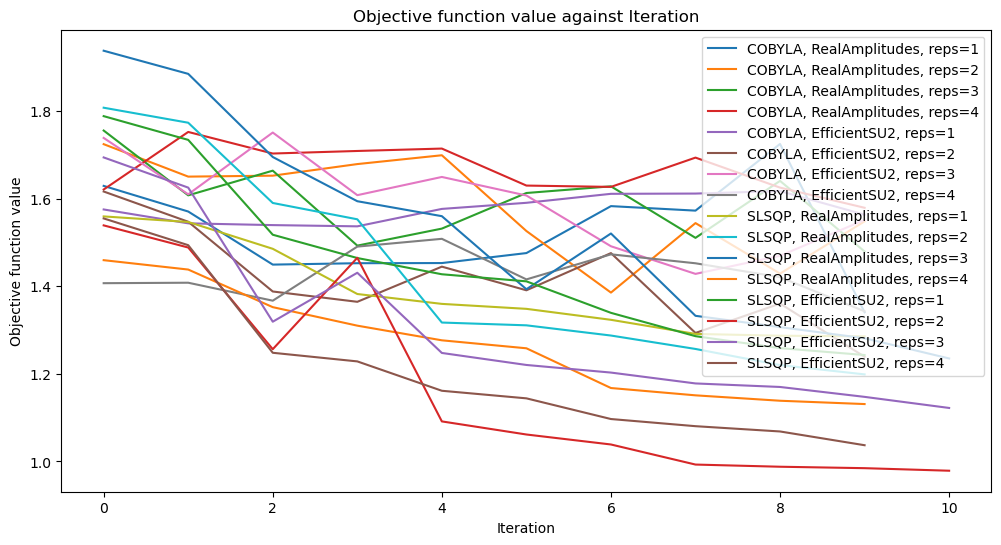

In [11]:
from functools import partial
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Define the dictionary outside the loop to hold objective function values
objective_func_vals_dict = {}

# Your updated callback function definition
def callback_graph(combo_identifier, objective_func_vals_dict, eval_count, mean):
    if combo_identifier not in objective_func_vals_dict:
        objective_func_vals_dict[combo_identifier] = []
    objective_func_vals_dict[combo_identifier].append(mean)

    # Clear the current output and plot anew for all combinations
    clear_output(wait=True)
    for identifier, values in objective_func_vals_dict.items():
        plt.plot(values, label=identifier)

    plt.title('Objective function value against Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Objective function value')
    plt.legend()
    plt.show()

results = []

for combo in combinations:
    optimizer = combo["optimizer"]
    ansatz = combo["ansatz"]
    reps = ansatz.reps
    optimizer_name = type(optimizer).__name__
    ansatz_name = type(ansatz).__name__
    combo_identifier = f"{optimizer_name}, {ansatz_name}, reps={reps}"
    feature_map = ZZFeatureMap(feature_dimension=feature_dimension, reps=1)

    # Create a unique callback for this combination
    unique_callback = partial(callback_graph, combo_identifier, objective_func_vals_dict)
    
    vqc = VQC(feature_map=feature_map,
              ansatz=ansatz,
              optimizer=optimizer,
              callback=unique_callback,  # Pass the unique callback here
              sampler=sampler)

    # The dictionary for this combo identifier is initialized here
    objective_func_vals_dict[combo_identifier] = []
    
    start_time = time.time()
    vqc.fit(train_features, train_labels)
    elapsed_time = time.time() - start_time
    score = vqc.score(test_features, test_labels)

    # Append results for this combination
    results.append({
        "combo_identifier": combo_identifier,
        "optimizer": optimizer_name,
        "ansatz": ansatz_name,
        "ansatz_reps": reps,
        "training_time": elapsed_time,
        "score": score
    })

# Ensure to process results here, e.g., by printing or plotting


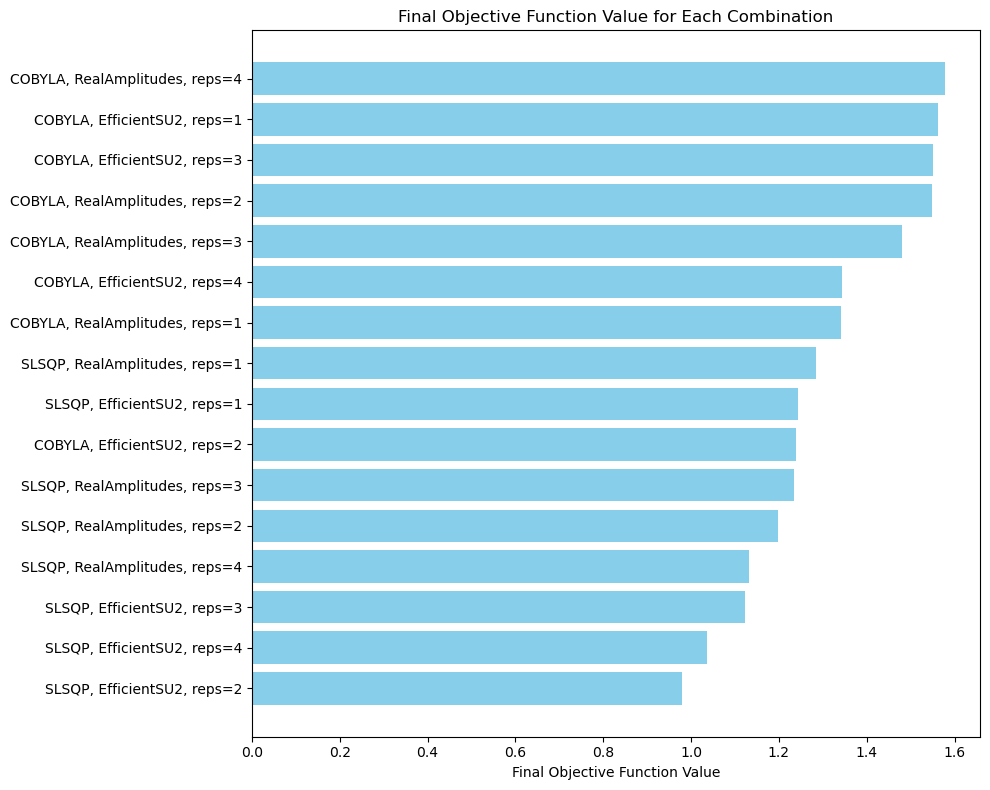

In [16]:
# Extract the final objective function value for each combination
final_vals = {key: values[-1] for key, values in objective_func_vals_dict.items()}

# Sort combinations by their final values for better visualization
sorted_combos = sorted(final_vals.items(), key=lambda x: x[1])

# Prepare data for plotting
labels = [combo[0] for combo in sorted_combos]
final_values = [combo[1] for combo in sorted_combos]

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(labels, final_values, color='skyblue')
plt.xlabel('Final Objective Function Value')
plt.title('Final Objective Function Value for Each Combination')
plt.tight_layout()
plt.show()


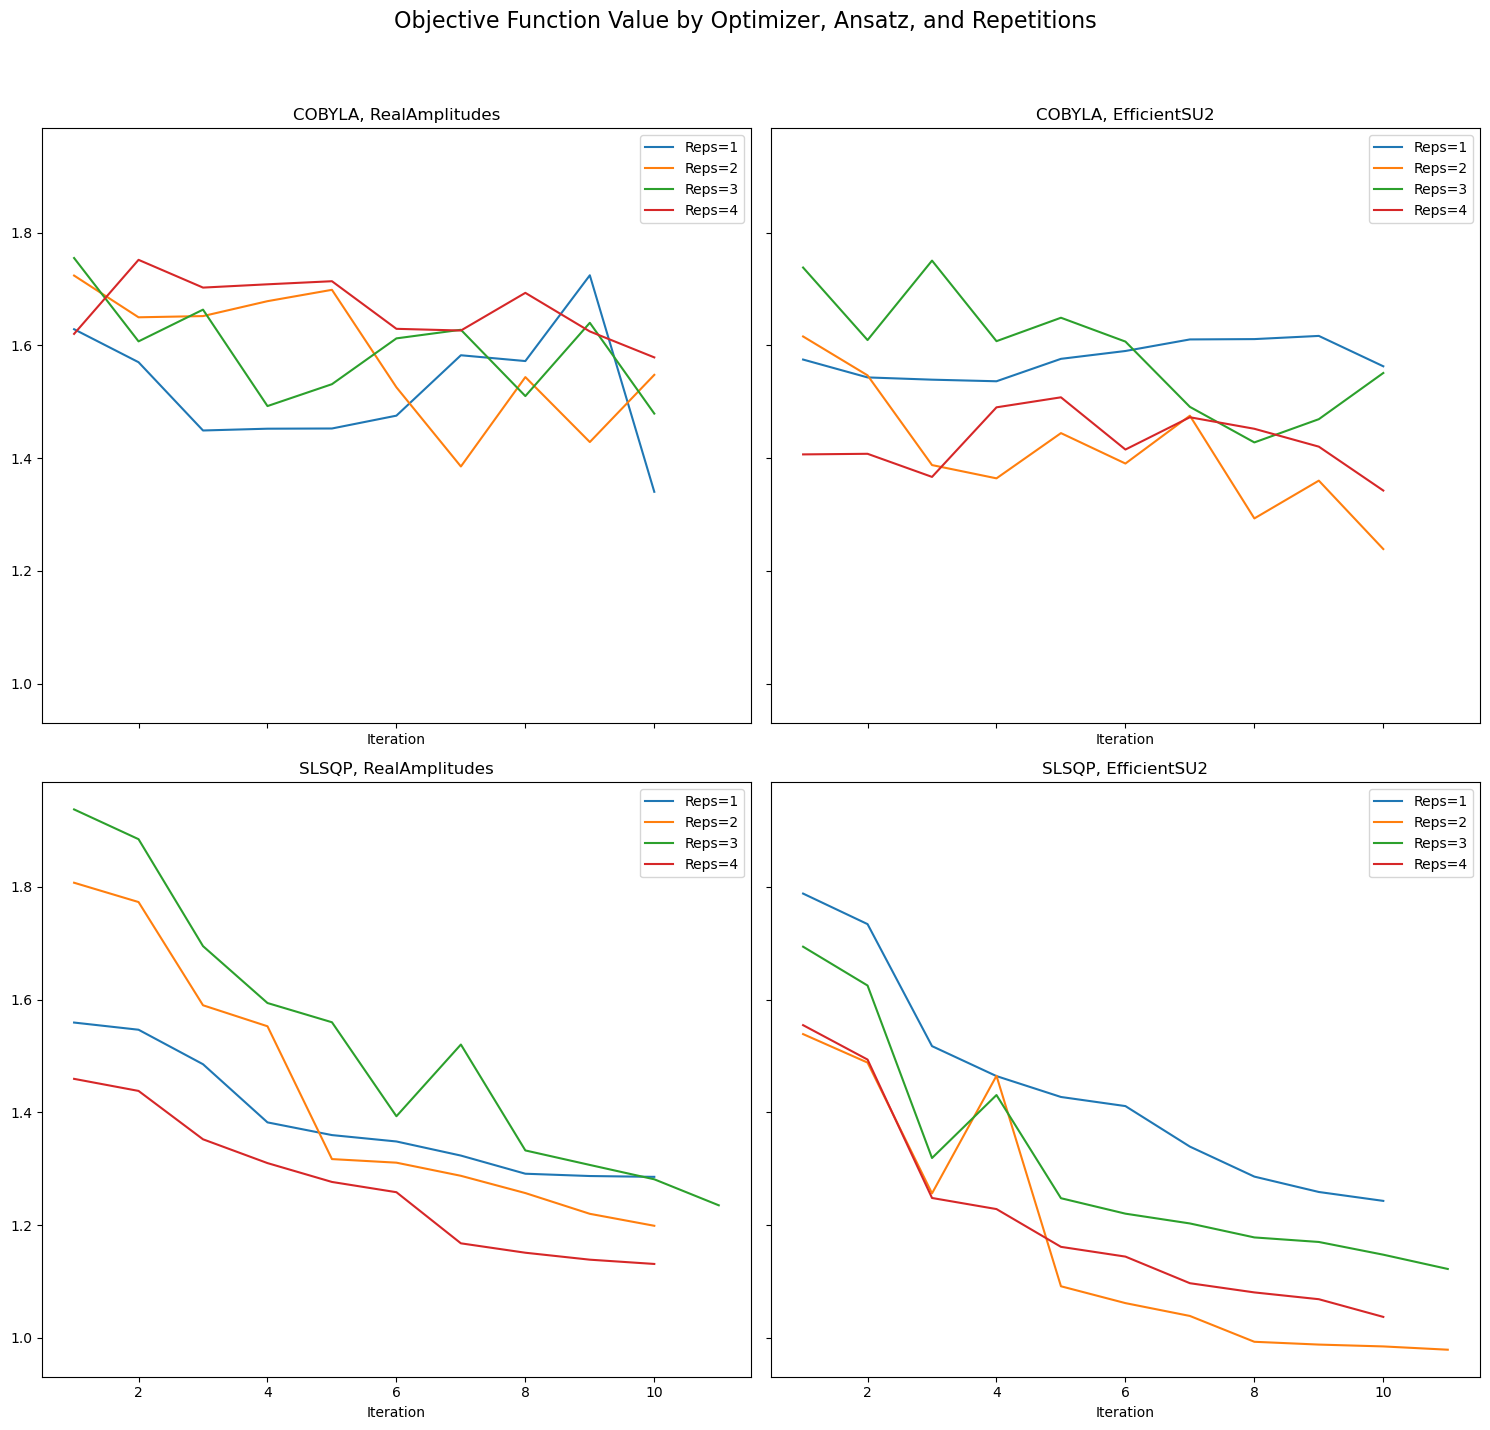

In [23]:
data = []
for combo, vals in objective_func_vals_dict.items():
    for iteration, value in enumerate(vals, 1):
        optimizer, ansatz, reps = combo.split(", ")
        data.append({"Optimizer": optimizer, "Ansatz": ansatz, "Reps": reps.split("=")[-1], "Iteration": iteration, "Value": value})
df = pd.DataFrame(data)

# Plotting
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), sharex=True, sharey=True)
axs = axs.flatten()

optimizers = df['Optimizer'].unique()
ansatzes = df['Ansatz'].unique()

for i, optimizer in enumerate(optimizers):
    for j, ansatz in enumerate(ansatzes):
        ax = axs[i * len(ansatzes) + j]
        subset = df[(df['Optimizer'] == optimizer) & (df['Ansatz'] == ansatz)]
        
        for reps in subset['Reps'].unique():
            reps_subset = subset[subset['Reps'] == reps]
            ax.plot(reps_subset['Iteration'], reps_subset['Value'], label=f'Reps={reps}')
        
        ax.set_title(f'{optimizer}, {ansatz}')
        ax.set_xlabel('Iteration')
        ax.legend()

plt.suptitle("Objective Function Value by Optimizer, Ansatz, and Repetitions", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


/var/folders/t0/7r1s1xhd3r588zrbxd8d1pk80000gn/T/ipykernel_42017/524942335.py:28: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(score_annotation, (0.5, max(df_objective_vals[column]) * 0.9), textcoords="axes fraction", ha="center")
/var/folders/t0/7r1s1xhd3r588zrbxd8d1pk80000gn/T/ipykernel_42017/524942335.py:29: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(training_time_annotation, (0.5, max(df_objective_vals[column]) * 0.8), textcoords="axes fraction", ha="center")


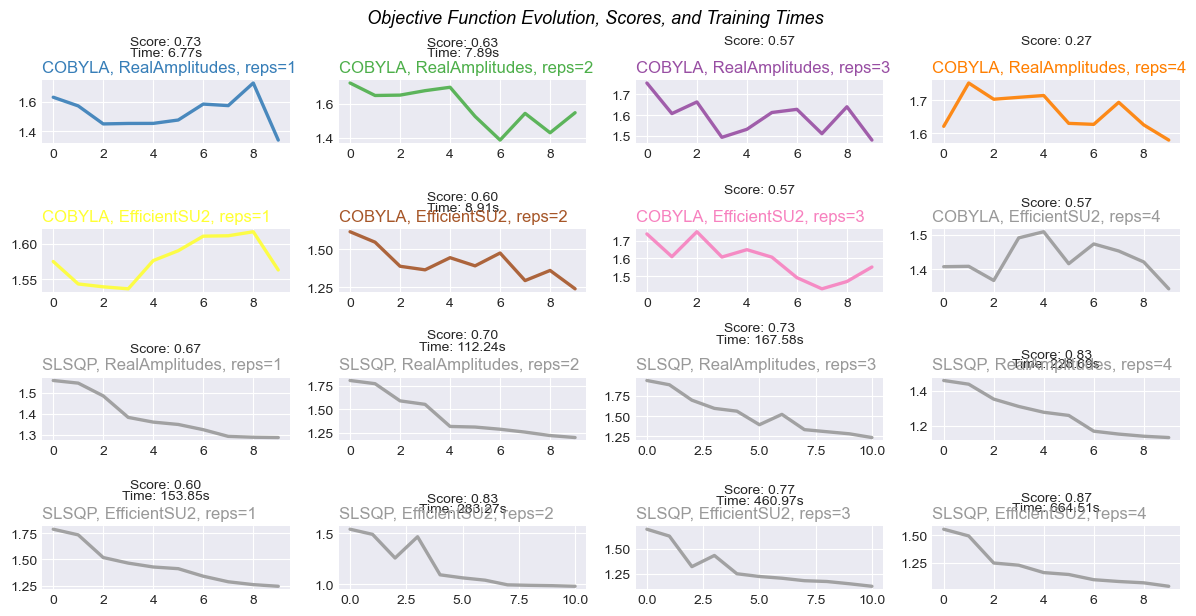

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Convert objective function values dictionary to a DataFrame
df_objective_vals = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in objective_func_vals_dict.items() ]))

# Convert the results list to a DataFrame
df_results = pd.DataFrame(results)

# Extract combo identifiers, scores, and training times for annotation
combo_scores = df_results.set_index('combo_identifier')['score'].to_dict()
combo_training_times = df_results.set_index('combo_identifier')['training_time'].to_dict()

# Plotting
plt.style.use('seaborn-v0_8-darkgrid')

palette = plt.get_cmap('Set1')
num = 0
for column in df_objective_vals:
    num += 1
    plt.subplot(4, 4, num)
    plt.plot(df_objective_vals.index, df_objective_vals[column], marker='', color=palette(num), linewidth=2.4, alpha=0.9, label=column)
    plt.title(column, loc='left', fontsize=12, fontweight=0, color=palette(num))
    score_annotation = f"Score: {combo_scores[column]:.2f}"
    training_time_annotation = f"Time: {combo_training_times[column]:.2f}s"
    plt.annotate(score_annotation, (0.5, max(df_objective_vals[column]) * 0.9), textcoords="axes fraction", ha="center")
    plt.annotate(training_time_annotation, (0.5, max(df_objective_vals[column]) * 0.8), textcoords="axes fraction", ha="center")
    plt.tight_layout()

plt.suptitle("Objective Function Evolution, Scores, and Training Times", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.show()


In [32]:
df

,Optimizer,Ansatz,Reps,Iteration,Value
0,COBYLA,RealAmplitudes,1,1,1.628787
1,COBYLA,RealAmplitudes,1,2,1.570297
2,COBYLA,RealAmplitudes,1,3,1.449185
3,COBYLA,RealAmplitudes,1,4,1.452360
4,COBYLA,RealAmplitudes,1,5,1.452715
...,...,...,...,...,...
158,SLSQP,EfficientSU2,4,6,1.144007
159,SLSQP,EfficientSU2,4,7,1.096807
160,SLSQP,EfficientSU2,4,8,1.080483
161,SLSQP,EfficientSU2,4,9,1.068428


TypeError: bar() missing 1 required positional argument: 'height'

In [17]:
end_time = time.time()
total_runtime = end_time - start_time
print(f"Total Notebook Runtime: {total_runtime} seconds")

Total Notebook Runtime: 1134.739249944687 seconds
